In [1]:
import tritonclient.http as httpclient
from PIL import Image
from utils.image import preprocess_one_image, preprocess_all_images, postprocess_detections, visualize_result
from utils.inference import warmup_onnx, warmup_triton

In [2]:
%reload_ext autoreload
%autoreload 2

## Inference

In [4]:
raw_image, input_image = preprocess_one_image("assets/apple.png")
infer_input = httpclient.InferInput("images", input_image.shape, datatype="FP32")
infer_input.set_data_from_numpy(input_image, binary_data=True)

In [5]:
client = httpclient.InferenceServerClient(url="localhost:9000")

In [6]:
responce = client.infer(model_name="yolov10s", inputs=[infer_input])

In [7]:
output = responce.as_numpy('output0')
output = postprocess_detections(output[0], init_h=704, init_w=1000, confidence_threshold=0.7)

print(output.shape)

(5, 6)


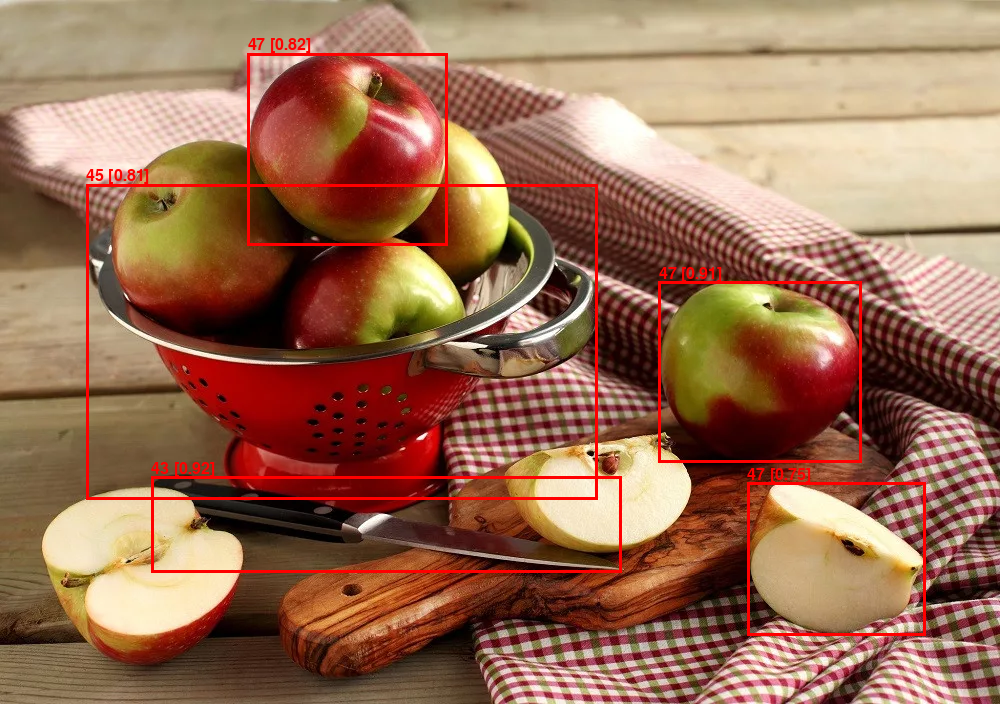

In [8]:
visualize_result(Image.fromarray(raw_image), output)

## Comparison

In [3]:
import random
import time

import numpy as np
import onnxruntime as ort

In [4]:
session = ort.InferenceSession(
    "triton-model-repository/yolov10s/1/model.onnx", 
    providers=['CPUExecutionProvider']
)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

warmup_onnx(session)

finished warming up ONNX Runtime...


In [5]:
client = httpclient.InferenceServerClient(url="localhost:9000")

warmup_triton(client)

finished warming up NVidia Triton Runtime...


In [6]:
image_batch = preprocess_all_images("assets")
batch = np.stack(image_batch, axis=0).astype(np.float32)

MAX_BATCH_SIZE = 8

In [7]:
times = {"triton": [], "onnx": []}

for batch_size in range(1, MAX_BATCH_SIZE+1):

    random_idxs = random.sample(range(batch.shape[0]), batch_size)
    batch_sample = batch[random_idxs]

    t1 = time.time()
    infer_input = httpclient.InferInput("images", batch_sample.shape, datatype="FP32")
    infer_input.set_data_from_numpy(batch_sample, binary_data=True)
    responce = client.infer(model_name="yolov10s", inputs=[infer_input])
    output_nt = responce.as_numpy('output0')
    t2 = time.time()
    times["triton"] += [(t2-t1)*1000]


    t3 = time.time()
    output_onnx = session.run([output_name], {input_name: batch_sample.astype(np.float32)})[0]
    t4 = time.time()
    times["onnx"]+= [(t4-t3)*1000]

    for out_onnx, out_nt in zip(output_onnx, output_nt):
        np.testing.assert_almost_equal(
            postprocess_detections(out_onnx), 
            postprocess_detections(out_nt),
            decimal=4
        )
    
    print(f"Batch size={batch_size}: " + \
          f"Triton {times['triton'][-1] / batch_size:.3f} ms/img, " + \
          f"ONNX[CPU]: {times['onnx'][-1] / batch_size:.3f} ms/img")

Batch size=1: Triton 141.249 ms/img, ONNX[CPU]: 688.123 ms/img
Batch size=2: Triton 131.055 ms/img, ONNX[CPU]: 858.990 ms/img
Batch size=3: Triton 141.393 ms/img, ONNX[CPU]: 663.755 ms/img
Batch size=4: Triton 108.876 ms/img, ONNX[CPU]: 717.707 ms/img
Batch size=5: Triton 94.017 ms/img, ONNX[CPU]: 652.893 ms/img
Batch size=6: Triton 92.839 ms/img, ONNX[CPU]: 652.248 ms/img
Batch size=7: Triton 95.649 ms/img, ONNX[CPU]: 724.533 ms/img
Batch size=8: Triton 95.586 ms/img, ONNX[CPU]: 625.818 ms/img
